# 1. Data Processing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [3]:
FLOWERS_PATH = os.path.join("drive", "MyDrive", "Gwak_tf_ATR", "datasets", "flowers")
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['1_ 2S1 [158 x 158]',
 '2_ BRDM_2 [128 x 129]',
 '3_ BTR_60 [128 x 128]',
 '4_ D7 [177 x 178]',
 '5_ T62 [172 x 173]',
 '6_ T-72 Variants A05 [138 x 139]',
 '7_ ZIL131 [ 192 x 193]',
 '8_ ZSU_23_4 [ 158 x 158]']

In [4]:
from collections import defaultdict###여기서 각각의 class에 대한 image들의 directory를 얻는 것.

image_paths = defaultdict(list)
#print(image_paths)
for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    #print(image_dir)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".JPG"):
            #print(filepath)
            image_paths[flower_class].append(os.path.join(image_dir, filepath))
#print(image_paths)##image paths라고 하는 놈은 전체의 directory를 가지고 있다

In [5]:
for paths in image_paths.values():#정확히 어떻게 sort하는 지는 모르겟지만, 이렇게 해서 나눈다.
    paths.sort()    

In [6]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)#class: daisy(0)
    plt.figure(figsize=(10,5))#그림 size 조절(-)
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):#class마다 2개씩
        example_image = mpimg.imread(example_image_path)
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        print(example_image.shape)#(imageshape : 158*158)
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# my_path = '/content/drive/MyDrive/add_packages'
# # !pip install --target=$my_path scipy

# import sys
# sys.path.append('/content/drive/MyDrive/add_packages')

In [21]:
from skimage.transform import resize

def prepare_image(image, target_width = 128, target_height = 128, max_zoom = 0.2):##resize하는 함수 정의
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = resize(image, (target_width, target_height))
    
    # Finally, the Convolution Neural Network expects colors represented as
    # 32-bit floats ranging from 0.0 to 1.0:
    return image.astype(np.float32) / 255

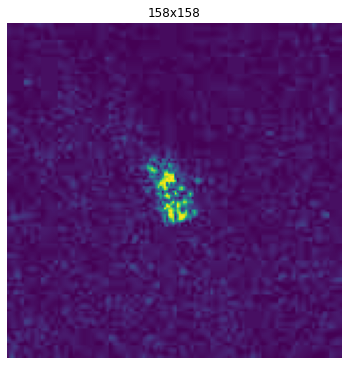

In [22]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

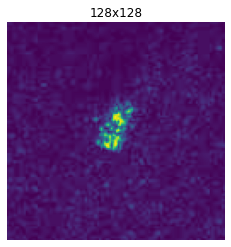

In [23]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(4, 4))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

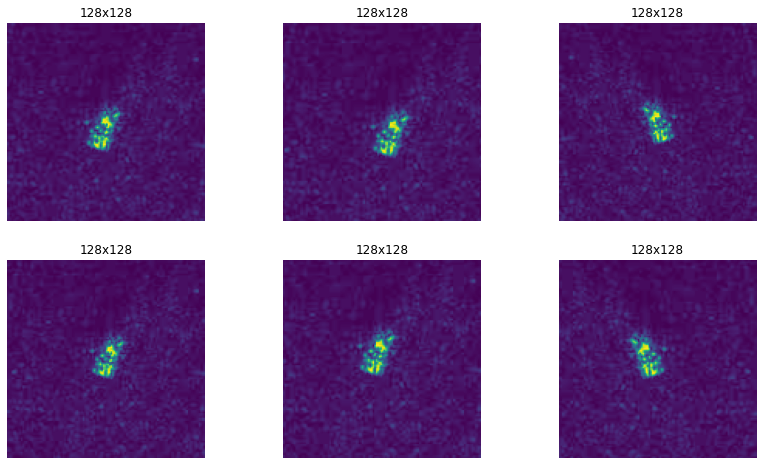

In [24]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

In [25]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'1_ 2S1 [158 x 158]': 0,
 '2_ BRDM_2 [128 x 129]': 1,
 '3_ BTR_60 [128 x 128]': 2,
 '4_ D7 [177 x 178]': 3,
 '5_ T62 [172 x 173]': 4,
 '6_ T-72 Variants A05 [138 x 139]': 5,
 '7_ ZIL131 [ 192 x 193]': 6,
 '8_ ZSU_23_4 [ 158 x 158]': 7}

In [26]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    #print(flower_class,'\n',paths)
    for path in paths:
        #print(path)
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))
        
print(flower_paths_and_classes)

[('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14931.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14932.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14933.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14934.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14935.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14936.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14937.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14938.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14939.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14940.JPG', 0), ('drive/MyDrive/Gwak_tf_ATR/datasets/fl

In [27]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

print(len(flower_paths_and_classes))
print(train_size)

np.random.shuffle(flower_paths_and_classes)#무조건 shuffle해야 됨

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]
##이게 데이터 나누는것

2112
1689


In [28]:
flower_paths_and_classes_train[:3]###여기 train만 있다.

[('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/1_ 2S1 [158 x 158]/HB14969.JPG',
  0),
 ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/5_ T62 [172 x 173]/HB15129.JPG',
  4),
 ('drive/MyDrive/Gwak_tf_ATR/datasets/flowers/flower_photos/7_ ZIL131 [ 192 x 193]/HB15129.JPG',
  6)]

In [29]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = np.stack(prepared_images)
    ##
    X_batch = X_batch.reshape(X_batch.shape[0],X_batch.shape[1],X_batch.shape[2],1)
    ## 흑백을 만들기 위해서 내가 추가한것(4D용)
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    ##
    
    ##one-hot으로 바꿔주기
    
    return X_batch, y_batch

X_batch.shape (4, 128, 128, 1)
(128, 128, 1)


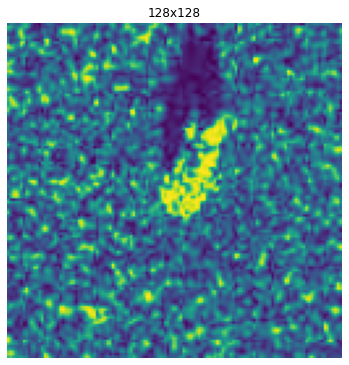

In [30]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)
print('X_batch.shape',X_batch.shape)

X_batch1= X_batch[1,:,:,:]
print(X_batch1.shape)
plt.figure(figsize=(6, 8))

X_batch1 = X_batch1.reshape(128,128)
plt.imshow(X_batch1)
plt.title("{}x{}".format(X_batch1.shape[1], X_batch1.shape[0]))
plt.axis("off")
plt.show()

In [31]:
X_batch.shape

(4, 128, 128, 1)

In [32]:
X_batch.dtype

dtype('float32')

In [33]:
y_batch

array([7, 2, 6, 5], dtype=int32)

In [34]:
y_batch.shape

(4,)

In [35]:
y_batch.dtype

dtype('int32')

In [36]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))
#여기에는 test만 있다.

In [37]:
X_test.shape

(423, 128, 128, 1)

In [38]:
y_test.shape

(423,)

In [39]:
len(X_test)

423

In [40]:
y_test

array([6, 1, 1, 4, 5, 7, 2, 4, 6, 5, 4, 4, 1, 3, 1, 4, 7, 3, 6, 4, 1, 4,
       4, 5, 7, 3, 2, 2, 0, 1, 3, 1, 1, 4, 3, 1, 0, 1, 7, 4, 6, 4, 7, 5,
       6, 7, 0, 1, 2, 7, 5, 3, 4, 4, 6, 6, 6, 6, 2, 3, 2, 1, 4, 5, 6, 5,
       5, 1, 6, 3, 5, 6, 1, 7, 0, 1, 1, 5, 4, 7, 6, 0, 6, 7, 1, 2, 2, 3,
       4, 4, 2, 7, 1, 3, 0, 6, 1, 5, 7, 6, 6, 7, 4, 5, 7, 6, 2, 1, 3, 0,
       7, 7, 6, 5, 1, 2, 4, 5, 5, 2, 2, 7, 4, 4, 6, 6, 2, 2, 0, 2, 6, 7,
       6, 6, 1, 4, 7, 1, 5, 4, 3, 0, 1, 0, 6, 7, 6, 2, 1, 7, 3, 4, 3, 6,
       0, 6, 0, 4, 1, 6, 4, 3, 4, 6, 5, 1, 1, 6, 2, 4, 5, 2, 7, 5, 0, 2,
       7, 6, 3, 5, 2, 5, 4, 4, 1, 2, 4, 7, 5, 7, 3, 0, 0, 1, 4, 2, 4, 1,
       1, 4, 6, 5, 5, 0, 4, 5, 7, 6, 6, 3, 3, 7, 5, 4, 7, 3, 6, 6, 5, 4,
       0, 2, 7, 5, 7, 0, 2, 5, 6, 0, 6, 7, 3, 1, 6, 0, 0, 4, 0, 1, 4, 2,
       0, 7, 1, 3, 6, 5, 1, 7, 2, 3, 2, 4, 0, 3, 1, 3, 2, 4, 5, 6, 2, 6,
       0, 2, 3, 3, 1, 4, 4, 6, 6, 2, 0, 1, 2, 6, 1, 4, 7, 4, 2, 6, 0, 7,
       2, 4, 4, 1, 1, 0, 2, 1, 6, 0, 7, 1, 6, 0, 3,

# 2. Training And Test

In [55]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow as tf2
import random
import matplotlib.pyplot as plt
tf2.random.set_seed(777)

In [48]:
# hyper parameters
learning_rate = 0.005#???
training_epochs = 30
batch_size = 50

n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size
print(n_iterations_per_epoch)

33


In [49]:

X = tf.placeholder(tf.float32, [None,  128, 128, 1])
X_img = X# img 128x128x1 (black/white)
#Y = tf.placeholder(tf.float32, [None, 8])]
#onehot모양이 아니라서
y = tf.placeholder(tf.int32, shape=[None])

In [50]:
# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)
keep_prob3 = tf.placeholder(tf.float32)
keep_prob4 = tf.placeholder(tf.float32)

In [51]:
# L1 ImgIn shape=(?, 128, 128, 1)
W1 = tf.Variable(tf.random_normal([9, 9, 1, 18], stddev=0.01))
#    Conv     -> (?, 120, 120, 18)
#    Pool     -> (?, 20, 20, 18)
print(W1)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='VALID')
print(L1)
L1 = tf.nn.relu(L1)
print(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 6, 6, 1],
                    strides=[1, 6, 6, 1], padding='SAME')
print(L1)
L1 = tf.nn.dropout(L1, keep_prob1)#keep_prob1 = 0.75
print(L1)


<tf.Variable 'Variable:0' shape=(9, 9, 1, 18) dtype=float32_ref>
Tensor("Conv2D:0", shape=(?, 120, 120, 18), dtype=float32)
Tensor("Relu:0", shape=(?, 120, 120, 18), dtype=float32)
Tensor("MaxPool:0", shape=(?, 20, 20, 18), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("dropout/Mul:0", shape=(?, 20, 20, 18), dtype=float32)


In [52]:
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L2 ImgIn shape=(?, 20, 20, 18)
W2 = tf.Variable(tf.random_normal([5, 5, 18, 36], stddev=0.01))
#    Conv      ->(?, 16, 16, 36)
#    Pool      ->(?, 4, 4, 36)
print(W2)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='VALID')
print(L2)
L2 = tf.nn.relu(L2)
print(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 4, 4, 1],
                    strides=[1, 4, 4, 1], padding='SAME')
print(L2)
L2 = tf.nn.dropout(L2, keep_prob2)#keep_prob2 = 0.75
print(L2)


<tf.Variable 'Variable_1:0' shape=(5, 5, 18, 36) dtype=float32_ref>
Tensor("Conv2D_1:0", shape=(?, 16, 16, 36), dtype=float32)
Tensor("Relu_1:0", shape=(?, 16, 16, 36), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 4, 4, 36), dtype=float32)
Tensor("dropout_1/Mul:0", shape=(?, 4, 4, 36), dtype=float32)


In [53]:
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
'''

# L3 ImgIn shape=(?, 4, 4, 36)
W3 = tf.Variable(tf.random_normal([4, 4, 36, 120], stddev=0.01))
print(W3)
#    Conv      ->(?, 1, 1, 120)
##    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 1 * 1 * 120) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='VALID')
print(L3)
L3 = tf.nn.relu(L3)
print(L3)
#L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
#                    1, 2, 2, 1], padding='SAME')##max pooling은할필요 xxx
L3 = tf.nn.dropout(L3, keep_prob3)#keep_prob3 = 0.75
print(L3)
L3_flat = tf.reshape(L3, [-1, 120 * 1 * 1])
print(L3_flat)

<tf.Variable 'Variable_2:0' shape=(4, 4, 36, 120) dtype=float32_ref>
Tensor("Conv2D_2:0", shape=(?, 1, 1, 120), dtype=float32)
Tensor("Relu_2:0", shape=(?, 1, 1, 120), dtype=float32)
Tensor("dropout_2/Mul:0", shape=(?, 1, 1, 120), dtype=float32)
Tensor("Reshape:0", shape=(?, 120), dtype=float32)


In [58]:
'''
Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
'''
init = tf2.initializers.GlorotUniform()
# or a oneliner with a little confusing brackets
W4 = tf2.Variable(tf2.initializers.GlorotUniform()(shape=[120 * 1 * 1, 400]))

# L4 FC 1x1x120 inputs -> 400 outputs

print(W4)
###xavier_init의 경우 처음할때만 된다. 2번하면 충돌
b4 = tf.Variable(tf.random_normal([400]))
print(b4)
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
print(L4)
L4 = tf.nn.dropout(L4, keep_prob4)#keep_prob4 = 0.5
print(L4)

<tf.Variable 'Variable_3:0' shape=(120, 400) dtype=float32>
<tf.Variable 'Variable_4:0' shape=(400,) dtype=float32_ref>
Tensor("Relu_3:0", shape=(?, 400), dtype=float32)
Tensor("dropout_3/Mul:0", shape=(?, 400), dtype=float32)


In [60]:
'''
Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
'''
init = tf2.initializers.GlorotUniform()
# L5 Final FC 400 inputs -> 10 outputs
W5 = tf2.Variable(tf2.initializers.GlorotUniform()(shape=[400, 8]))

print(W5)
b5 = tf.Variable(tf.random_normal([8]))
print(b5)
flower_logits = tf.matmul(L4, W5) + b5
#shape(?,8)
print(flower_logits)##마지막 logits은 one-hot으로 나온다. 이제 이것을 softmax로 나타낸다.
Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")
print('Y_proba',Y_proba)

'''
Tensor("add_1:0", shape=(?, 10), dtype=float32)
'''

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    print('logits,y',flower_logits,y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    
    
# define cost/loss & optimizer
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#    logits=logits, labels=Y))
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


<tf.Variable 'Variable_5:0' shape=(400, 8) dtype=float32>
<tf.Variable 'Variable_6:0' shape=(8,) dtype=float32_ref>
Tensor("add_1:0", shape=(?, 8), dtype=float32)
Y_proba Tensor("Y_proba:0", shape=(?, 8), dtype=float32)
logits,y Tensor("add_1:0", shape=(?, 8), dtype=float32) Tensor("Placeholder_1:0", shape=(?,), dtype=int32)


In [61]:
# initialize

#sess = tf.Session()
#sess.run(tf.global_variables_initializer())


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
# train my model
    
    print('Learning started. It takes sometime.')
    for epoch in range(training_epochs):
        avg_cost = 0
        for i in range(n_iterations_per_epoch):
            print(".", end="")
            #batch_xs, batch_ys = prepare_batch(flower_paths_and_classes_train, batch_size)
            #feed_dict = {X: batch_xs, Y: batch_ys}
            #c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
            
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            c, _=sess.run([loss,optimizer], feed_dict={X: X_batch, y: y_batch, keep_prob1: 0.75, keep_prob2:0.75, keep_prob3 : 0.75, keep_prob4 : 0.5}) #training이란 변수는 이전의 코드에서만 적용           
            avg_cost += c / n_iterations_per_epoch
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch, keep_prob1: 1, keep_prob2:1, keep_prob3 : 1, keep_prob4 : 1})
        
        print("  Train accuracy:", acc_train, 'avg_cost',avg_cost)

        #print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob1: 1, keep_prob2:1, keep_prob3 : 1, keep_prob4 : 1})
    print("Test accuracy:", acc_test)

    print('Learning Finished!')

# Test model and check accuracy

# if you have a OOM error, please refer to lab-11-X-mnist_deep_cnn_low_memory.py



# Get one and predict
r = random.randint(0, len(X_test) - 1)
print("Label: ", y[r])
print("Prediction: ", sess.run(
    tf.argmax(Y_proba, 1), feed_dict={X: X_test[r,128,128,1], keep_prob1: 1, keep_prob2:1, keep_prob3 : 1, keep_prob4 : 1}))


Learning started. It takes sometime.
.................................  Train accuracy: 0.24 avg_cost 2.550900943351514
.................................  Train accuracy: 0.18 avg_cost 2.121336564873204
.................................  Train accuracy: 0.26 avg_cost 1.9623534896157
.................................  Train accuracy: 0.18 avg_cost 1.9160317254788952
.................................  Train accuracy: 0.16 avg_cost 1.8570896423224243
.................................  Train accuracy: 0.24 avg_cost 1.8274099176580252
.................................  Train accuracy: 0.32 avg_cost 1.836620388608991
.................................  Train accuracy: 0.26 avg_cost 1.8273875857844493
.................................  Train accuracy: 0.26 avg_cost 1.7767851786179973
.................................  Train accuracy: 0.28 avg_cost 1.8039659550695708
.................................  Train accuracy: 0.3 avg_cost 1.7767004352627376
.................................  Train accur

IndexError: ignored

In [ ]:
# Get one and predict
sess = tf.Session()
sess.run(tf.global_variables_initializer())
r = random.randint(0, len(X_test) - 1)
print(r)
print(y_test)
print("Label: ", y_test[r])
print(X_test[r,:,:,:].shape)
#print(X_test[r,:,:,:])
print(X_test[r:r+1].shape)
#print(X_test[r:r+1])
print("Prediction: ", sess.run(tf.argmax(Y_proba, 1), feed_dict={X: X_test[r:r+1], keep_prob1: 1, keep_prob2:1, keep_prob3 : 1, keep_prob4 : 1}))

plt.imshow(X_test[r:r+1].
           reshape(128, 128), cmap='Greys', interpolation='nearest')
plt.show()

322
[6 3 0 2 0 3 0 0 1 3 5 1 5 6 4 5 3 5 5 0 3 1 3 6 1 1 5 2 4 7 0 2 2 3 3 6 5
 0 3 0 4 5 6 3 5 0 6 2 7 3 5 4 2 4 7 2 6 7 1 2 1 0 6 7 7 4 4 2 1 7 5 3 4 6
 1 2 6 3 4 5 4 4 6 6 4 6 1 2 2 6 4 5 7 7 2 7 4 3 3 3 6 0 1 1 2 7 1 6 5 4 3
 3 0 6 6 3 6 4 0 4 6 3 6 3 4 3 2 6 3 2 1 5 5 5 6 7 2 0 2 4 6 7 4 6 0 7 4 3
 5 0 6 5 6 2 5 1 0 4 5 1 7 2 1 0 4 4 0 3 2 7 3 4 5 2 4 2 2 5 0 2 0 3 2 4 5
 1 0 4 7 0 0 0 4 2 1 7 5 3 7 4 1 0 3 3 1 6 1 5 1 6 6 6 7 3 6 2 0 1 1 5 3 5
 4 6 6 5 1 5 3 5 3 6 7 7 3 1 3 1 7 7 2 7 1 5 4 7 1 3 1 7 5 7 1 6 3 2 3 3 3
 3 5 0 4 5 6 4 7 0 5 2 6 5 3 2 2 1 0 1 6 2 1 7 1 7 0 3 6 4 6 0 0 5 2 6 6 5
 1 7 7 5 7 1 4 5 1 4 6 2 0 5 0 6 5 6 6 7 4 7 6 6 0 5 7 3 3 1 5 1 3 3 4 2 3
 4 7 1 7 5 2 7 5 6 3 3 7 3 3 5 0 7 7 1 1 0 4 5 3 6 4 5 4 2 5 2 1 2 7 0 3 3
 4 1 3 6 3 4 5 7 4 5 5 7 5 4 7 6 7 2 3 4 5 7 7 5 0 2 4 7 7 0 0 5 1 6 5 7 2
 0 4 5 1 5 6 7 4 1 1 2 5 4 3 2 2]
Label:  7
(128, 128, 1)
(1, 128, 128, 1)
Prediction:  [7]


NameError: name 'mnist' is not defined